# Temporal Difference Learning with Nim

## 1 - Initialization

In [21]:
#import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from SA import SA

from AgentQ import AgentQ
from AgentSARSA import AgentSARSA
from Opponent import Opponent

# Variables initialization
# RL
stepSize = 0.5 # alpha
discount = 1 # no discounting (gamma)
epsilon = 0.5 # for the e-greedy policy
# Nim
board_ini = sorted([5,5,5,5])
sarsa_flag = False
runMax = int(3E4)

# Function initialization
def init_board():
    """
    Return a random board based on board_ini
    """
    for i in range(len(board_ini)):
        board[i] = rnd.randint(0,board_ini[i])
    board.sort()
    
    if board[-1] == 0:
        return init_board()
    return board

## 2 - Reinforcement Learning

In [22]:
# Board and agent
board = list(board_ini)
board_end = [0] * len(board_ini)
if sarsa_flag:
    agent = AgentSARSA(SA(board), stepSize, discount, epsilon)
else:
    agent = AgentQ(SA(board), stepSize, discount, epsilon)
oppLearning = Opponent(SA(board), policy="optimal", epsilon=0.1)
oppOptimal = Opponent(SA(board), policy="optimal")

# Learning curves parameters
learning_win = []
greedy_win = []
optimalMoves = []
optimalMoves_runNb = []
optMoveFound_list = []
optMoveFound_runNb = []

# Learning
for run in range(runMax):
    if (run+1) % 100 == 0:
        clear_output()
        print("run   : {0}/{1}\n".format(run+1, runMax))
    
    board = init_board()
    
    agentIsFirst = rnd.randint(0,1)
    if agentIsFirst == False:
        oppLearning.move(board)
        if board == board_end:
            learning_win.append(0)
            continue
    
    while True:
        agent.move(board)
        if board == board_end:
            agent.winUpdate()
            learning_win.append(1)
            break
        
        oppLearning.move(board)
        if board == board_end:
            agent.loseUpdate()
            learning_win.append(0)
            break
            
        agent.updateQ(board)
    
    ### Test the agent every 100 runs on 100 more runs
    if (run+1) % 100 == 0:
        optMovePossible = 0.
        optMoveMade = 0.
        wins = 0.
        for _ in range(100):
            board = init_board()
            before = 0
            for i in range(len(board)):
                before ^= board[i]
            while before == 0:
                board = init_board()
                before = 0
                for i in range(len(board)):
                    before ^= board[i]
            
            while True:
                before = 0
                for i in range(len(board)):
                    before ^= board[i]
                if before != 0:
                    optMovePossible += 1
                    
                agent.greedyMove(board)
               
                after = 0
                for i in range(len(board)):
                    after ^= board[i]
                if after == 0:
                    optMoveMade += 1
                
                if board == board_end:
                    wins += 1.
                    break
                
                oppOptimal.move(board)
                if board == board_end:
                    wins += 0.
                    break
        
        greedy_win.append(wins)
        optimalMoves.append(optMoveMade/optMovePossible*100)
        optimalMoves_runNb.append(run)
        
        optMoveNb = 0.
        optMoveFound = 0.
        for s in agent.states:
            board = list(agent.states[s])
            for heap in range(len(board)):
                for action in range(1,1+board[heap]):
                    temp_board = list(board)
                    temp_board[heap] -= action
                              
                    nimSum = 0
                    for i in range(len(temp_board)):
                        nimSum ^= temp_board[i]
                    
                    if nimSum == 0:
                        optMoveNb += 1.
                        a = agent.actions.index([heap,action])
                        if agent.Q[s][a] >= max(agent.Q[s])-1E-1 and agent.Q[s][a] >= 0.5:
                            optMoveFound += 1.
        optMoveFound_list.append(optMoveFound/optMoveNb*100)
        optMoveFound_runNb.append(run)

run   : 30000/30000



## 3 - Learning curves

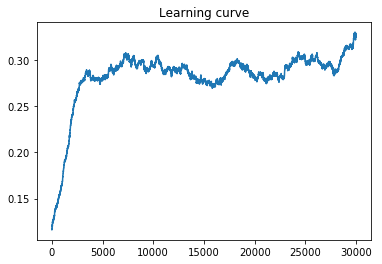

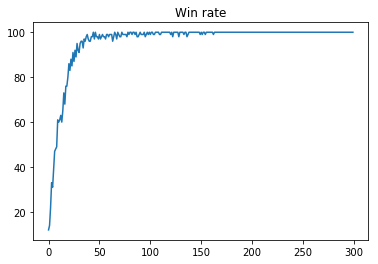

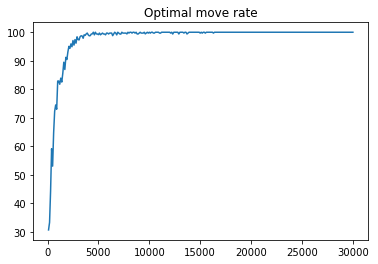

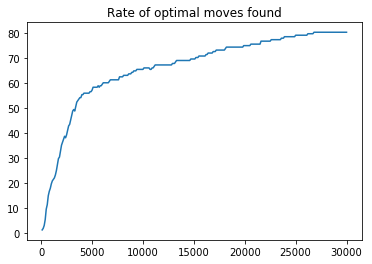

In [23]:
# Window averaging
half_window = 1000
learning_win_ave = []

for i in range(len(learning_win)):
    startIndex = i - half_window
    if startIndex < 0:
        startIndex = 0
        
    endIndex = i + half_window + 1
    if endIndex > len(learning_win):
        endIndex = len(learning_win)
    
    learning_win_ave.append(float(sum(learning_win[startIndex:endIndex])) / (len(learning_win[startIndex:endIndex])))

plt.plot(learning_win_ave)
plt.title("Learning curve")
plt.show()

plt.plot(greedy_win)
plt.title("Win rate")
plt.show()

plt.plot(optimalMoves_runNb, optimalMoves)
plt.title("Optimal move rate")
plt.show() 

plt.plot(optMoveFound_runNb, optMoveFound_list)
plt.title("Rate of optimal moves found")
plt.show()     

## 4 - Test of the agent after learning

In [25]:
trials = 2000
wins = 0
winStart = 0
optMove = 0
optDone = 0
for i in range(trials):
    board = init_board()
        
    agentIsFirst = rnd.randint(0,1)
    if agentIsFirst == False:
        oppOptimal.move(board)
        if board == board_end:
            continue
    
    before = 0
    for i in range(len(board)):
        before ^= board[i]
    if before != 0:
        winStart += 1
    while True:
        before = 0
        for i in range(len(board)):
            before ^= board[i]
        if before != 0:
            optMove += 1
            
        agent.greedyMove(board)
       
        after = 0
        for i in range(len(board)):
            after ^= board[i]
        if after == 0:
            optDone += 1
        
        if board == board_end:
            wins += 1
            break
        
        oppOptimal.move(board)
        if board == board_end:
            break

print "Win rate = {}/{} = {:.2f}%\n\nOptimal moves rate = {}/{} = {:.2f}%\n".format(wins, winStart, float(wins)/float(winStart)*100, \
              optDone, optMove, float(optDone)/float(optMove)*100)

optMoveNb = 0.
optMoveFound = 0.

for s in agent.states:
    board = list(agent.states[s])
    for heap in range(len(board)):
        for action in range(1,1+board[heap]):
            temp_board = list(board)
            temp_board[heap] -= action
                      
            nimSum = 0
            for i in range(len(temp_board)):
                nimSum ^= temp_board[i]
            
            if nimSum == 0:
                optMoveNb += 1.
                a = agent.actions.index([heap,action])
                if agent.Q[s][a] >= max(agent.Q[s])-1E-1 and agent.Q[s][a] >= 0.5:
                    optMoveFound += 1.
            
            
print "Optimal moves found = {:.2f}%".format(optMoveFound/optMoveNb*100)

Win rate = 999/999 = 100.00%

Optimal moves rate = 3283/3283 = 100.00%

Optimal moves found = 80.36%
